# General: Brightness / Luminosity of HII regions

In [1]:
%matplotlib inline
import pylab as pl
from astropy import units as u
from astropy import constants
import radio_beam
import pylab as pl
from dust_emissivity import dust
#from constants import frequency as cfreq, distance


from astropy.visualization import quantity_support
quantity_support()  
pl.matplotlib.style.use('default')

In [2]:
cfreq = 100*u.GHz
distance = 8.1*u.kpc

In [3]:
def dens(Qlyc=1e45*u.s**-1, R=0.1*u.pc, alpha_b=2e-13*u.cm**3*u.s**-1):
    return (((3 * Qlyc)/(4 * np.pi * R**3 * alpha_b))**0.5).to(u.cm**-3)

def EMfunc(Qlyc=1e45*u.s**-1, R=0.1*u.pc, alpha_b=2e-13*u.cm**3*u.s**-1):
    return (R * (((3 * Qlyc)/(4 * np.pi * R**3 * alpha_b))**0.5)**2).to(u.cm**-6*u.pc)

def tau(nu, EM, Te=7000*u.K):
    # eq 4.60 of https://www.cv.nrao.edu/~sransom/web/Ch4.html
    return 3.28e-7 * (Te/(1e4*u.K))**-1.35 * (nu/u.GHz)**-2.1 * (EM/(u.cm**-6*u.pc))

def Tb(Te=7000*u.K, nu=cfreq, EM=EMfunc()):
    return Te * (1-np.exp(-tau(nu=nu, EM=EM, Te=Te)))
    #return (8.235e-2 * (Te/(u.K))**-0.35 * (nu/u.GHz)**-2.1 * (EM/u.cm**-6/u.pc)*u.K).to(u.K)

def Tb_beamdiluted(Te=7000*u.K, nu=cfreq, R=0.1*u.pc, Qlyc=1e45*u.s**-1, beam=4000*u.au):
    tb = Tb(Te=Te, nu=nu, EM=EMfunc(R=R, Qlyc=Qlyc))
    if beam < R:
        return tb
    else:
        return (tb * (R/beam)**2).to(u.K)

def Snu_freefree(Te=7000*u.K, nu=cfreq, EM=None, R=0.1*u.pc, Qlyc=1e45*u.s**-1, beam=4000*u.au,
                 angular_beam=0.5*u.arcsec):
    if EM is None:
        tb = Tb(Te=Te, nu=nu, EM=EMfunc(R=R, Qlyc=Qlyc))
    else:
        tb = Tb(Te=Te, nu=nu, EM=EM)
        
    angular_beam = radio_beam.Beam(angular_beam) if angular_beam.unit.is_equivalent(u.arcsec) else angular_beam.to(u.sr)
        
    if beam < R:
        return tb.to(u.mJy, u.brightness_temperature(frequency=nu, beam_area=angular_beam))
    else:
        return (tb * (R/beam)**2).to(u.mJy, u.brightness_temperature(frequency=nu, beam_area=angular_beam))

def gff(nu, Te=1e4*u.K, Zi=1):
    """
    Draine eqn 10.7
    """
    valid_check =  (Zi * (nu/u.GHz) / (Te/(1e4*u.K))**1.5)
    if np.any(valid_check < 0.14):
        raise ValueError("Invalid approximation")
    elif np.any(valid_check > 250):
        # eqn 10.9
        return np.log(np.exp(5.960-3**0.5/np.pi*np.log(Zi*(nu/u.GHz)*(Te/(1e4*u.K))**-1.5)) + np.exp(1))
    return 6.155 * (Zi * (nu/u.GHz))**-0.118 * (Te/(1e4*u.K))**0.177
    
def freefree_draine_coeff(nu, Te=1e4*u.K, Zi=1):
    """
    Draine eqn 10.1, 10.2
    """
    const = 8/3 * (2*np.pi/3)**0.5 * constants.e.esu**6/constants.m_e**2/constants.c**3 * (constants.m_e/(constants.k_B*Te))**0.5
    unit = u.erg/u.s/u.Hz*u.cm**3
    assert np.abs(const.to(unit) - 5.444e-41*unit) < 0.001e-41*unit
    gaunt = gff(nu=nu, Te=Te)
    boltz = np.exp(-constants.h*nu / (constants.k_B*Te))
    temfac = (Te/(1e4*u.K))**-0.5
    # this is multiplied by density squared
    return const.to(unit) * boltz * temfac * u.sr**-1 * Zi**2 * gaunt

assert np.abs(freefree_draine_coeff(1*u.GHz) - 3.35e-40*u.erg*u.cm**3/u.s/u.Hz/u.sr).value < 0.01e-40

def freefree_draine(nu, EM, Te=1e4*u.K):
    coef = freefree_draine_coeff(nu=nu, Te=Te)
    assert coef.unit.is_equivalent(u.cm**3*u.erg/u.Hz/u.s/u.sr)
    return (coef*EM).to(u.erg/u.s/u.cm**2/u.Hz/u.sr)
    
def snu_dust(density=1e4*u.cm**-3, Td=40*u.K, radius=4000*u.au, distance=distance, cfreq=cfreq):
    mass = (density * 2.8 * u.Da * 4/3. * radius**3).to(u.M_sun)
    print(mass)
    beam = radio_beam.Beam((radius/distance).to(u.arcsec,u.dimensionless_angles()))
    flux = dust.snuofmass(nu=cfreq, mass=mass, beamomega=beam, temperature=Td, distance=distance)
    return flux

### Some value checks: these match Draine's values exactly (there are assertions above that enforce this)

In [4]:
freefree_draine_coeff(1*u.GHz)

<Quantity 3.35099167e-40 cm3 erg / (Hz s sr)>

In [5]:
freefree_draine(1*u.GHz, EM=1e6*u.cm**-6*u.pc)

<Quantity 1.03400799e-15 erg / (cm2 Hz s sr)>

## Set up PaA emission calculation (and halpha and hbeta)

In [6]:
# from table in Draine
alpha_b_5e3 = 4.53e-13*u.cm**3*u.s**-1
alpha_b_1e4 = 2.59e-13*u.cm**3*u.s**-1
alpha_b_2e4 = 1.43e-13*u.cm**3*u.s**-1
alpha_b_beta_1e4 = 3.03e-14*u.cm**3*u.s**-1

def alpha_eff(T, line='beta'):
    """ H-alpha recombination coefficient.  eqn 14.8, 14.9 in draine 2001"""
    T4 = (T/(1e4*u.K)).decompose().value
    if line == 'alpha':
        return 1.17e-13 * T4**(-0.942-0.031*np.log(T4)) * u.cm**3*u.s**-1
    elif line == 'beta':
        return 3.03e-14 * T4**(-0.874-0.058*np.log(T4)) * u.cm**3*u.s**-1

hb_to_paa_1e4 = 0.336
alpha_paa = alpha_eff(1e4, line='beta') * hb_to_paa_1e4

from pyspeckit.spectrum.models import hydrogen
wl_paa = hydrogen.wavelength['paschena']*u.um
e_paa = wl_paa.to(u.erg, u.spectral())
nu_paa = wl_paa.to(u.Hz, u.spectral())

wl_hbeta = hydrogen.wavelength['balmerb']*u.um
nu_hbeta = wl_hbeta.to(u.Hz, u.spectral())

wl_halpha = hydrogen.wavelength['balmera']*u.um
nu_halpha = wl_halpha.to(u.Hz, u.spectral())

ha_to_hb_1e4=2.86

def snu_halpha(Te=10000*u.K, EM=EMfunc(alpha_b=alpha_b_1e4), angular_area=4*np.pi*u.sr):
    jhb_4p = 1.24e-25 * u.erg * u.cm**3 / u.s
    alpha_rel = alpha_eff(T=Te, line='beta') / alpha_b_beta_1e4
    flux = EM * jhb_4p * ha_to_hb_1e4
    return (flux/nu_halpha).to(u.mJy)/angular_area


def snu_hbeta(Te=10000*u.K, EM=EMfunc(alpha_b=alpha_b_1e4), angular_area=4*np.pi*u.sr):
    jhb_4p = 1.24e-25 * u.erg * u.cm**3 / u.s
    flux = EM * jhb_4p
    return (flux/nu_hbeta).to(u.mJy)/angular_area

def snu_paa(Te=10000*u.K, EM=EMfunc(alpha_b=alpha_b_1e4), angular_area=4*np.pi*u.sr):
    # temperature dependence factor: jhb ~ alpha, so this accounts for the T-dependence of j
    # (which is not explicitly given in Draine)
    alpha_rel = alpha_eff(T=Te, line='beta') / alpha_b_beta_1e4
    jhb_4p = 1.24e-25 * u.erg * u.cm**3 / u.s * hb_to_paa_1e4 * alpha_rel
    flux = EM * jhb_4p
    return (flux/nu_paa).to(u.mJy)/angular_area

functools.partial(<function ammonia_radex at 0x7fc4f292c8c0>, interpolator=None)


# Calculations for NIR emission line / radio free free

Using some simplifying assumptions, what is the expected surface brightness in Paschen $\alpha$ vs free-free continuum?

Assumptions:
 * EM = $10^6$ cm$^{-6}$ pc  (which we prove below is $\tau<<1$)
 * $T_{e} = 10^4$ K


Bally's equation:
$$ 4.88\times10^{17} I_{H\alpha} = EM$$

In [7]:
# some values to use about the PaA/radio ratio
# PaA surface brightness, free-free surface brightness at PaA
# free-free at 5 GHz from two methods
# optical depth at 5 GHz
# PaA / radio free-free ratio
(
 snu_paa(Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr),
 freefree_draine(nu=nu_paa, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr),
 Snu_freefree(nu=5*u.GHz, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc, angular_beam=1*u.sr).to(u.MJy)/u.sr,
 freefree_draine(nu=5*u.GHz, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr),
 tau(5*u.GHz, EM=1e6*u.cm**-6*u.pc, Te=1e4*u.K),
  snu_paa(Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr)/(Snu_freefree(nu=5*u.GHz, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc, angular_beam=1*u.sr).to(u.MJy)/u.sr )
)


(<Quantity 6.40060704 MJy / sr>,
 <Quantity 9.17648799 MJy / sr>,
 <Quantity 85.31502648 MJy / sr>,
 <Quantity 85.51397531 MJy / sr>,
 <Quantity 0.01116958>,
 <Quantity 0.07502321>)

### Some sanity checks: What is the line-to-continuum brightness ratio for PaA, HBeta, Halpha?

In [8]:
(snu_paa(Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr) / freefree_draine(nu=nu_paa, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr),
 snu_hbeta(Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr) / freefree_draine(nu=nu_hbeta, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr),
 snu_halpha(Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr) / freefree_draine(nu=nu_halpha, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc).to(u.MJy/u.sr))

(<Quantity 0.69750073>, <Quantity 5.20981836>, <Quantity 9.21375514>)

### Disagreement w/John's numbers here:

In [9]:
# John's calculation: he got EM=6.231e3 -> 1.5e-16 erg/s/cm^2/arcsec^2
(snu_paa(Te=1e4*u.K, EM=6.231e3*u.cm**-6*u.pc) * nu_paa ).to(u.erg/u.s/u.cm**2/u.arcsec**2)

<Quantity 1.4983357e-15 erg / (arcsec2 cm2 s)>

In [10]:
frq = 10*u.GHz
Te = (1e4)*u.K
EM_ = 1e6*u.cm**-6*u.pc
angbm = 1*u.sr
sfreefree = Snu_freefree(nu=frq, Te=Te, EM=EM_, angular_beam=angbm).to(u.MJy)/u.sr
spaa = snu_paa(Te=Te, EM=EM_).to(u.MJy/u.sr)
taux = tau(nu=frq, EM=EM_, Te=Te)
print(f"At {frq}, {Te}, {EM_} in {angbm}, \n free-free={sfreefree}  =  {sfreefree.to(u.mJy/u.arcsec**2)}, \n paa={spaa}  =  {spaa.to(u.mJy/u.arcsec**2)}, \n tau={taux}")
#print(f"At {Te}, {EM} in {angbm}, paa={spaa}")
print(f"PaA/freefree={spaa/sfreefree}")

At 10.0 GHz, 10000.0 K, 1000000.0 pc / cm6 in 1.0 sr, 
 free-free=79.94293418605102 MJy / sr  =  1.8790131436677098 mJy / arcsec2, 
 paa=6.400607040426754 MJy / sr  =  0.15044262358977153 mJy / arcsec2, 
 tau=0.002605396609895643
PaA/freefree=0.08006469997123992


In [11]:
frqs = [0.1, 1,5,10,20]*u.GHz
_ = list(zip(frqs,
         Snu_freefree(nu=frqs, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc, angular_beam=1*u.sr).to(u.MJy)/u.sr,
         Snu_freefree(nu=frqs, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc, angular_beam=1*u.sr) / Snu_freefree(nu=1*u.GHz, Te=1e4*u.K, EM=1e6*u.cm**-6*u.pc, angular_beam=1*u.sr),
         tau(nu=frqs, EM=1e6*u.cm**-6*u.pc, Te=1e4*u.K),
         tau(nu=1*u.GHz, EM=1e6*u.cm**-6*u.pc, Te=1e4*u.K) / tau(nu=frqs, EM=1e6*u.cm**-6*u.pc, Te=1e4*u.K),
        ))
for row in _:
    print("{0}: S={1}, S/S_1GHz={2}, tau={3}, tau/tau_1GHz={4}".format(*row))

0.1 GHz: S=3.072358374480745 MJy / sr, S/S_1GHz=0.035760649358541154, tau=41.2927535068487, tau/tau_1GHz=0.007943282347242812
1.0 GHz: S=85.91450182229244 MJy / sr, S/S_1GHz=1.0, tau=0.328, tau/tau_1GHz=1.0
5.0 GHz: S=85.31502648385526 MJy / sr, S/S_1GHz=0.9930224196646434, tau=0.011169579783472694, tau/tau_1GHz=29.365473577200476
10.0 GHz: S=79.94293418605102 MJy / sr, S/S_1GHz=0.9304940666641686, tau=0.002605396609895643, tau/tau_1GHz=125.89254117941674
20.0 GHz: S=74.66391464991582 MJy / sr, S/S_1GHz=0.8690490320755442, tau=0.0006077302482676971, tau/tau_1GHz=539.7131390694253


## Summary:

* PaA / Free Free = 0.08 times some factors
$$
\newcommand{\paa}{{\mathrm{Pa}\alpha}}
$$


$$S_{\paa}(T_4,EM) = 6.4 \left(\frac{EM}{10^6 \mathrm{~cm}^{-6}  \mathrm{~pc}}\right)\left( T_4^{-0.874-0.058 \ln T_4} \right) \mathrm{MJy~sr}^{-1} $$

$$S_{ff}(\nu,T_4,EM) = 79.9 \left(\frac{EM}{10^6 \mathrm{~cm}^{-6} \mathrm{~pc}}\right) \left( T_4^{-1.35} \right) \left(\frac{\nu}{10 GHz}\right)^{-0.1} \mathrm{MJy~sr}^{-1} $$

$$\frac{S_{\paa}}{S_{ff}(\nu)} = 0.08 \left(\frac{\nu}{10 GHz}\right)^{0.1}$$

# Below here are sanity checks and other unrelated things

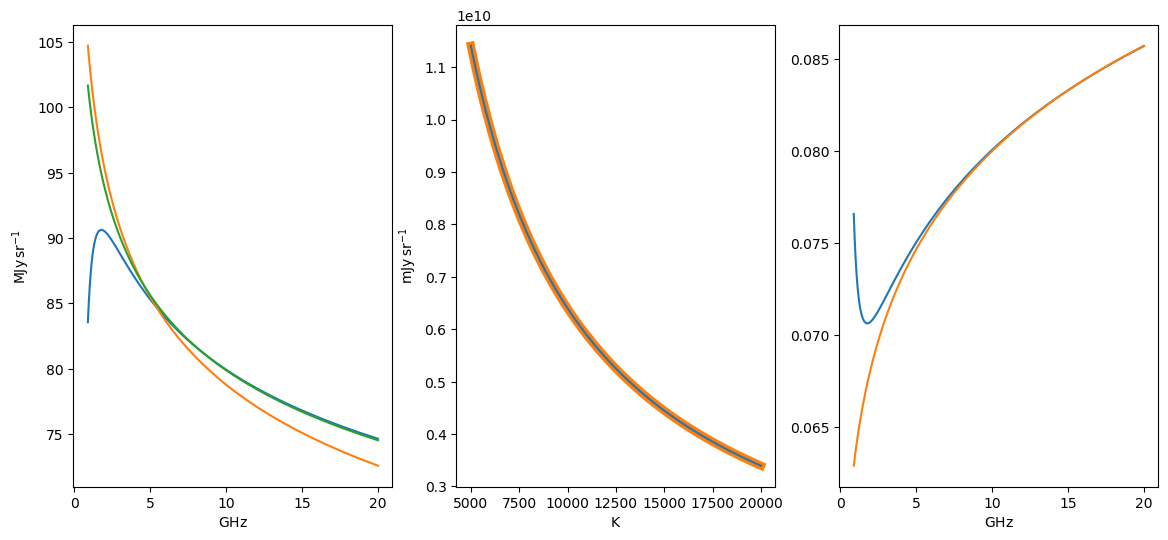

In [12]:
# Sanity checks: do the approximations above fit?

frqs = np.geomspace(0.9, 20)*u.GHz
Te = (1e4)*u.K
EM_ = 1e6*u.cm**-6*u.pc
pl.figure(figsize=(14,6))
pl.subplot(1,3,1)
pl.plot(frqs, Snu_freefree(nu=frqs, Te=Te, EM=EM_, angular_beam=1*u.sr).to(u.MJy)/u.sr)
pl.plot(frqs, freefree_draine(nu=frqs, Te=Te, EM=EM_))
pl.plot(frqs, 79.9*(frqs/(10*u.GHz))**-0.1*u.MJy/u.sr)
pl.subplot(1,3,2)
Tes = np.geomspace(5000,20000)*u.K
pl.plot(Tes, snu_paa(Te=Tes, EM=EM_))
pl.plot(Tes, 6.4*(Tes/(1e4*u.K))**((-0.874-0.058*np.log(Tes/(1e4*u.K))))*u.MJy/u.sr, linewidth=6, zorder=-5)
pl.subplot(1,3,3)
pl.plot(frqs, snu_paa(Te=Te, EM=EM_) / (Snu_freefree(nu=frqs, Te=Te, EM=EM_, angular_beam=1*u.sr)/u.sr))
pl.plot(frqs, 0.08 * (frqs/(10*u.GHz))**0.1 )

In [62]:
(1.5e-16*u.erg/u.s/u.cm**2/nu_paa).to(u.mJy)

<Quantity 9.38449225e-05 mJy>

In [73]:
(freefree_draine(nu=5*u.GHz, EM=(1*u.cm**-6*u.pc)) * (0.15*u.arcsec)**2).to(u.Jy)

<Quantity 4.52240391e-11 Jy>

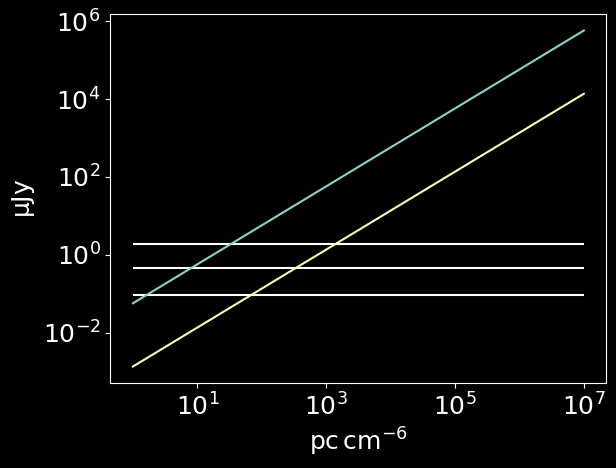

In [67]:
EMs = np.logspace(0,7)*u.cm**-6*u.pc
pl.loglog(EMs, (freefree_draine(nu=5*u.GHz, Te=Te, EM=EMs) * np.pi * (3*u.arcsec)**2).to(u.uJy))
pl.loglog(EMs, snu_paa(Te=Te, EM=EMs)*(3*u.arcsec)**2)
pl.hlines(np.array([1,5,20])*1.5e-16*u.erg/u.s/u.cm**2/nu_paa, EMs.min(), EMs.max(), color='w',)

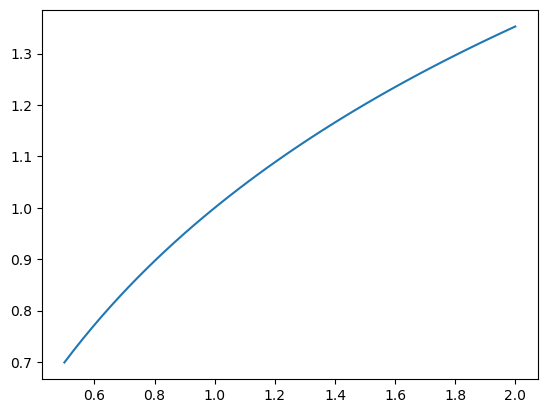

In [13]:
# ratio depends on temperatures....
def tratio(T4):
    return T4**(-0.874-0.058*np.log(T4)) / T4**-1.35

pl.plot(np.linspace(0.5, 2), tratio(np.linspace(0.5                                                , 2)))

In [14]:
dark_rn_pess = (((22*u.ph/(500*u.s) + 0.435*u.ph/u.s) * (e_paa/u.ph) / (24*u.cm/2)**2 / np.pi / nu_paa).to(u.mJy)  / (0.806*u.arcsec)**2).to(u.MJy/u.sr)
dark_rn_opt = (((6.2*u.ph/(500*u.s) + 0.0123*u.ph/u.s) * (e_paa/u.ph) / (24*u.cm/2)**2 / np.pi / nu_paa).to(u.mJy)  / (0.806*u.arcsec)**2).to(u.MJy/u.sr)

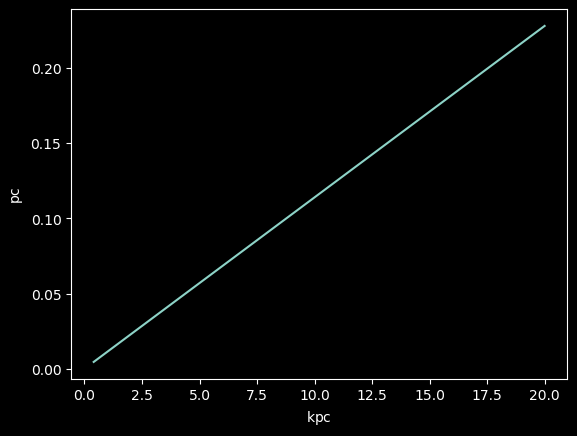

In [15]:
pl.matplotlib.style.use('dark_background')
distances = np.geomspace(0.4, 20)*u.kpc
resoln = (distances * 2.35*u.arcsec).to(u.pc, u.dimensionless_angles())
pl.plot(distances, resoln)

In [16]:
fig = pl.gcf()
fig.get_facecolor()


(0.0, 0.0, 0.0, 1.0)

<Figure size 640x480 with 0 Axes>

(<Quantity 0.01996324 MJy / sr>,
 <Quantity 0.07985296 MJy / sr>,
 <Quantity 0.0023693 MJy / sr>)

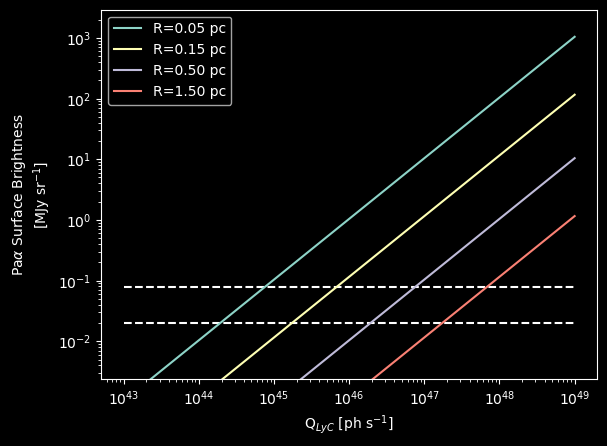

In [17]:
Qlyc = np.logspace(43,49,100)*u.s**-1
for radius in (0.05, 0.15, 0.5, 1.5)*u.pc:
    EMs = EMfunc(R=radius, Qlyc=Qlyc)
    snus = snu_paa(Te=1e4*u.K, EM=EMs).to(u.MJy/u.sr)
    pl.loglog(Qlyc, snus, label=f'R={radius:0.2f}')
pl.legend(loc='best')
#pl.hlines(u.Quantity([dark_rn_opt, dark_rn_pess])*5, Qlyc.min(), Qlyc.max(), linestyle='--', color='k')
fivesig = 1.5e-16*5*(u.erg/u.cm**2/u.s/u.arcsec**2 / nu_paa).to(u.MJy/u.sr)
twentysig = 4*fivesig
bgcolor=pl.gcf().get_facecolor()
color = (1-bgcolor[0], 1-bgcolor[1], 1-bgcolor[2], bgcolor[3])
pl.hlines(u.Quantity([fivesig, twentysig]), Qlyc.min(), Qlyc.max(), linestyle='--', color=color)
pl.ylim(dark_rn_opt.value, pl.gca().get_ylim()[1])
pl.xlabel("Q$_{LyC}$ [ph s$^{-1}$]")
pl.ylabel("Pa$\\alpha$ Surface Brightness\n[MJy sr$^{-1}$]")
pl.savefig(os.path.expanduser("~/spam_paschenalpha/paper/extended_HII_region_detectability.pdf"), bbox_inches='tight')
fivesig, twentysig, dark_rn_opt

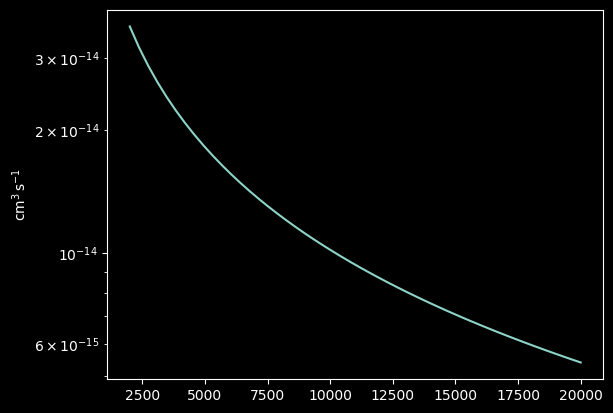

In [18]:
pl.semilogy(np.linspace(2000,20000), alpha_eff(np.linspace(2000,20000))*hb_to_paa_1e4)

From 4.60 + 4.61 of http://www.cv.nrao.edu/~sransom/web/Ch4.html

Where does 4.67 come from?  It's mJy, apparently?  I can't reproduce that from anything.

$$S_{\nu} = 4.67 \left[1-\exp\left(-3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{EM}{\mathrm{cm}^{-6}\mathrm{pc}} \right) \right]$$

$$T_{B,\nu} = T_e \left[1-\exp\left(-3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{EM}{\mathrm{cm}^{-6}\mathrm{pc}} \right) \right]$$

$$EM = R n_h^2 = \frac{3 Q_{lyc}}{4 \pi R^2 \alpha_b}$$

$$Q_{lyc}(S_{\nu})$$

$$EM = (-3.28\times10^{-7})^{-1} \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} \ln\left(1-\frac{S_{\nu}}{4.67 \mathrm{mJy}}\right) \mathrm{cm}^{-6}~\mathrm{pc}$$

$$EM = (-3.28\times10^{-7})^{-1} \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} \ln\left(1-\frac{T_{B,\nu}}{T_e}\right) \mathrm{cm}^{-6}~\mathrm{pc}$$

$$Q_{lyc} = \frac{4}{3} \pi R^2 \alpha_b (-3.28\times10^{-7})^{-1} \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} \ln\left(1-\frac{T_{B,\nu}}{T_e}\right) \mathrm{s}^{-1}$$

$$(-3.28\times10^{-7}) \frac{Q_{lyc}}{ \mathrm{s}^{-1}} \left( \frac{4}{3} \pi R^2 \alpha_b\right)^{-1}\left[ \ln\left(1-\frac{T_{B,\nu}}{T_e}\right)\right]^{-1} =  \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} $$

$$S_{\nu}(Q_{lyc})  = 4.67 \left[1-\exp\left(-3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{3 Q_{lyc}}{4 \pi R^2 \alpha_b} \right) \right]$$

$$S_{\nu}(Q_{lyc})  \approx 4.67 \left(3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{3 Q_{lyc}}{4 \pi R^2 \alpha_b} \right) $$

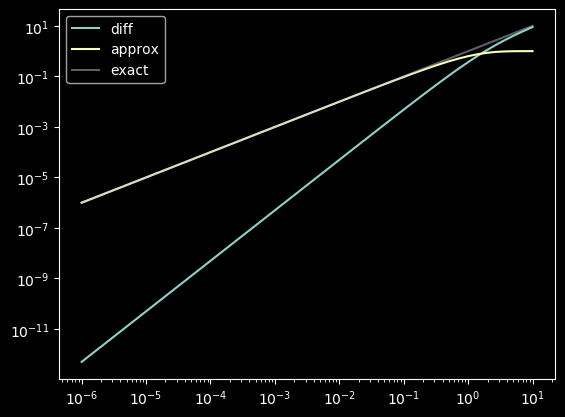

In [19]:
# sanity check on the Taylor expansion... the argument of the above equation must be <0.1
x = np.logspace(-6,1)
pl.loglog(x,(x-(1-np.exp(-x))), label='diff')
pl.loglog(x,(1-np.exp(-x)), label='approx')
pl.loglog(x,x, label='exact', alpha=0.5)
pl.legend(loc='best')

In [20]:
# density corresponding to 5-sigma
snu_dust(density=1.5e7*u.cm**-3).to(u.mJy)

10.020454589088208 solMass


<Quantity 0.73071413 mJy>

In [21]:
# density corresponding to TOO BRIGHT
snu_dust(density=3e8*u.cm**-3).to(u.mJy)

200.40909178176418 solMass


<Quantity 13.3395209 mJy>

In [22]:
Snu_freefree(Qlyc=1e47*u.s**-1, R=4000*u.au)

<Quantity 5.18080244 mJy>

In [23]:
Snu_freefree(Qlyc=1e47*u.s**-1, R=2000*u.au)

<Quantity 5.17799147 mJy>

In [24]:
Snu_freefree(Qlyc=1e46*u.s**-1, R=2000*u.au)

<Quantity 0.51813649 mJy>

In [25]:
Snu_freefree(Qlyc=1e46*u.s**-1, R=100*u.au)

<Quantity 0.50345846 mJy>

In [26]:
# Quoted in paper
Snu_freefree(Qlyc=1e47*u.s**-1, R=100*u.au), np.log10(dens(R=100*u.au, Qlyc=1e47*u.s**-1).value)

(<Quantity 3.93367731 mJy>, 6.776052579448274)

In [27]:
Snu_freefree(Qlyc=1e47*u.s**-1, R=50*u.au), np.log10(dens(R=50*u.au, Qlyc=1e47*u.s**-1).value)

(<Quantity 2.01663528 mJy>, 7.227597572944246)

In [28]:
# Quoted in paper (How small does the HII region have to be, and how dense, before O-stars can be hidden?)
Snu_freefree(Qlyc=1e47*u.s**-1, R=25*u.au), np.log10(dens(R=25*u.au, Qlyc=1e47*u.s**-1).value)

(<Quantity 0.55929758 mJy>, 7.679142566440218)

In [29]:
Snu_freefree(Qlyc=1e48*u.s**-1, R=25*u.au), np.log10(dens(R=25*u.au, Qlyc=1e48*u.s**-1).value)

(<Quantity 0.5593506 mJy>, 8.179142566440218)

In [30]:
Snu_freefree(Qlyc=1e46*u.s**-1, R=25*u.au), np.log10(dens(R=25*u.au, Qlyc=1e45*u.s**-1).value)

(<Quantity 0.33785749 mJy>, 6.679142566440218)

In [31]:
dens(1e45*u.s**-1, R=0.1*u.pc)

<Quantity 201.56488713 1 / cm3>

In [32]:
# angular size in Sgr B2
distance = 8.4*u.kpc
R = (0.5*u.arcsec * distance).to(u.pc, u.dimensionless_angles())
print(R)

0.020362174606600513 pc


In [33]:
# observed limit (approx)
beam = radio_beam.Beam(0.5*u.arcsec)
cfreq = 95*u.GHz
(1*u.mJy).to(u.K, u.brightness_temperature(beam, cfreq))

The inputs to `brightness_temperature` have changed. Frequency is now the first input, and angular area is the second, optional input.


<Quantity 0.54165999 K>

In [34]:
beam, beam.major, beam.sr

(Beam: BMAJ=0.5 arcsec BMIN=0.5 arcsec BPA=0.0 deg,
 <Quantity 0.5 arcsec>,
 <Quantity 6.65815901e-12 sr>)

In [35]:
dens(1e45*u.s**-1, R=R)

<Quantity 2193.70711513 1 / cm3>

In [36]:
EMfunc(1e45*u.s**-1, R=R)

<Quantity 97989.92943559 pc / cm6>

In [37]:
Tb(EM=EMfunc(1e45*u.s**-1, R=R))

<Quantity 0.02297578 K>

In [38]:
Tb(EM=EMfunc(1e46*u.s**-1, R=R))

<Quantity 0.22975441 K>

In [39]:
Tb(EM=EMfunc(1e47*u.s**-1, R=R))

<Quantity 2.29720474 K>

In [40]:
Tb_beamdiluted(Qlyc=np.logspace(45,50)*u.s**-1, R=1000*u.au)

<Quantity [2.53301056e-02, 3.20386705e-02, 4.05238866e-02, 5.12562206e-02,
           6.48306921e-02, 8.19998299e-02, 1.03715338e-01, 1.31180768e-01,
           1.65918090e-01, 2.09851821e-01, 2.65415308e-01, 3.35684962e-01,
           4.24549725e-01, 5.36924910e-01, 6.79021866e-01, 8.58687756e-01,
           1.08583325e+00, 1.37297017e+00, 1.73588622e+00, 2.19448994e+00,
           2.77386600e+00, 3.50558843e+00, 4.42934750e+00, 5.59495318e+00,
           7.06478306e+00, 8.91674251e+00, 1.12477943e+01, 1.41780858e+01,
           1.78556438e+01, 2.24614960e+01, 2.82148939e+01, 3.53780111e+01,
           4.42590275e+01, 5.52118340e+01, 6.86296669e+01, 8.49288196e+01,
           1.04517354e+02, 1.27742876e+02, 1.54813887e+02, 1.85692630e+02,
           2.19966012e+02, 2.56717429e+02, 2.94446189e+02, 3.31105816e+02,
           3.64338795e+02, 3.91941592e+02, 4.12475106e+02, 4.25770983e+02,
           4.33002364e+02, 4.36162007e+02] K>

In [41]:
# 0.2 arcsec = FWHM / 2.35 = 0.5 / 2.35
r_unresolved = (0.2*u.arcsec*distance).to(u.cm, u.dimensionless_angles())
volume = (4/3.*np.pi*r_unresolved**3)
muh2 = 2.8*u.Da
dustdens_0pt5mJy = (dust.massofsnu(nu=cfreq, snu=0.5*u.mJy, temperature=40*u.K, distance=distance) / volume / muh2).to(u.cm**-3)
dustdens_5mJy = (dust.massofsnu(nu=cfreq, snu=5*u.mJy, temperature=40*u.K, distance=distance) / volume / muh2).to(u.cm**-3)
dustdens_10mJy = (dust.massofsnu(nu=cfreq, snu=10*u.mJy, temperature=40*u.K, distance=distance) / volume / muh2).to(u.cm**-3)
print("{0:g} {1:g}".format(dustdens_0pt5mJy,dustdens_10mJy))
print("column at 0.5 mJy: {0}".format(dust.colofsnu(nu=cfreq, snu_per_beam=0.5*u.mJy/beam.sr, temperature=40*u.K)))
print("column at 10 mJy: {0}".format(dust.colofsnu(nu=cfreq, snu_per_beam=10*u.mJy/beam.sr, temperature=40*u.K)))
print("tau at 0.5 mJy: {0}".format(dust.tauofsnu(nu=cfreq, snu_per_beam=0.5*u.mJy/beam.sr, temperature=40*u.K)))
print("tau at 10 mJy: {0}".format(dust.tauofsnu(nu=cfreq, snu_per_beam=10*u.mJy/beam.sr, temperature=40*u.K)))
print("Mass of a 0.5 mJy dust source at 40K: {0}".format(dust.massofsnu(nu=cfreq, snu=0.5*u.mJy, temperature=40*u.K, distance=distance)))
print("Mass of a 5 mJy dust source at 40K: {0}".format(dust.massofsnu(nu=cfreq, snu=5*u.mJy, temperature=40*u.K, distance=distance)))
print("Mass of a 10 mJy dust source at 40K: {0}".format(dust.massofsnu(nu=cfreq, snu=10*u.mJy, temperature=40*u.K, distance=distance)))
dustdens_10msun = (10*u.M_sun / volume / muh2).to(u.cm**-3)
dustdens_100msun = (100*u.M_sun / volume / muh2).to(u.cm**-3)
snu10msun = dust.snuofmass(nu=cfreq, mass=10*u.M_sun, temperature=40*u.K, distance=distance)
snu100msun = dust.snuofmass(nu=cfreq, mass=100*u.M_sun, temperature=40*u.K, distance=distance)
print("Flux of a 10 Msun source at 40K: {0}".format(snu10msun))
print("Flux of a 100 Msun source at 40K: {0}".format(snu100msun))

5.70156e+07 1 / cm3 1.14058e+09 1 / cm3
column at 0.5 mJy: 8.446647874513474e+23 1 / cm2
column at 10 mJy: 1.8169306662517537e+25 1 / cm2
tau at 0.5 mJy: 0.007197550334834606
tau at 10 mJy: 0.15482413993734565
Mass of a 0.5 mJy dust source at 40K: 8.86518764992355 solMass
Mass of a 5 mJy dust source at 40K: 88.67249321471951 solMass
Mass of a 10 mJy dust source at 40K: 177.3449864294813 solMass
Flux of a 10 Msun source at 40K: 0.0005638259887029255 Jy
Flux of a 100 Msun source at 40K: 0.005638259887029256 Jy


The inputs to `brightness_temperature` have changed. Frequency is now the first input, and angular area is the second, optional input.


Didn't save fig


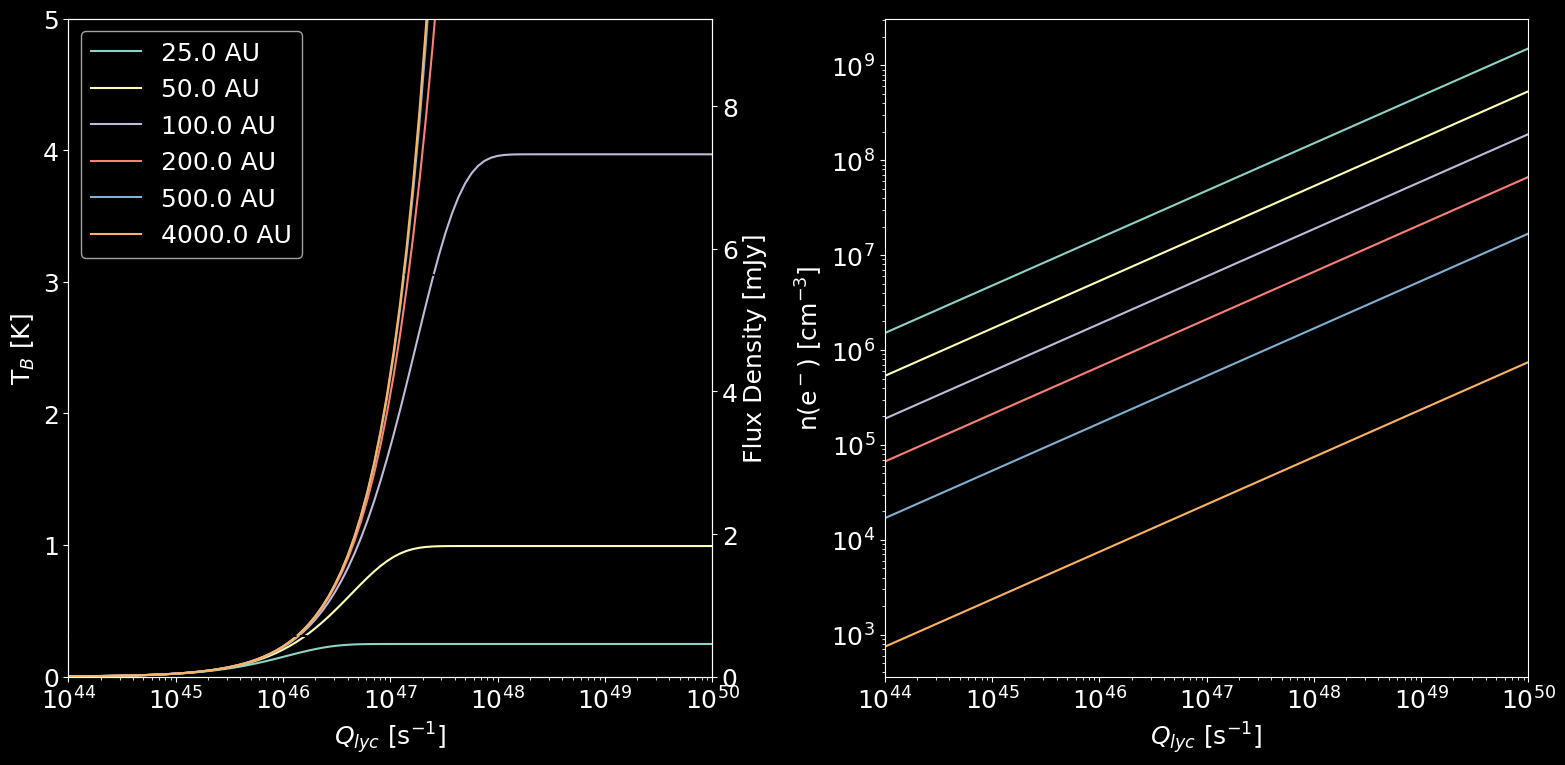

In [42]:
pl.figure(figsize=(16,8))
pl.rcParams['font.size']=18
ax1 = pl.subplot(1,2,1)
ax2 = pl.subplot(1,2,2)
Qlyc = np.logspace(44,50,100)*u.s**-1
beam_pc = (0.5*u.arcsec * distance).to(u.pc, u.dimensionless_angles())
for source_size in [25,50,100,200,500,4000]*u.au:
    tb = Tb_beamdiluted(Qlyc=Qlyc, R=source_size, beam=beam_pc)
    density = dens(Qlyc=Qlyc, R=source_size)

    ax1.semilogx(Qlyc, tb, label=source_size)
    ax2.loglog(Qlyc, density, label=source_size)
ax1.fill_between([Qlyc[0].value, Qlyc[-1].value],
                 [0.05*5]*2, [0.16*5]*2, color='k', alpha=0.2, zorder=-10)
ax1twin = ax1.twinx()
ax1twin.set_ylim(0, (5*u.K).to(u.mJy, u.brightness_temperature(beam, cfreq)).value)
ax1twin.set_ylabel('Flux Density [mJy]')
ax1.set_ylim(0,5)
ax1.set_xlim(Qlyc.min().value, Qlyc.max().value)
ax2.set_xlim(Qlyc.min().value, Qlyc.max().value)
ax1.set_xlabel("$Q_{lyc}$ [s$^{-1}$]")
ax2.set_xlabel("$Q_{lyc}$ [s$^{-1}$]")
ax1.set_ylabel("T$_B$ [K]")
ax2.set_ylabel("n(e$^-$) [cm$^{-3}$]")
# multiply the N(H_2) densities by 2 to get to n(e)
ax2.hlines(dustdens_10msun.to(u.cm**-3).value*2, Qlyc[0].value, Qlyc[-1].value,color='k', linestyle='--')
ax2.hlines(dustdens_100msun.to(u.cm**-3).value*2, Qlyc[0].value, Qlyc[-1].value,color='k', linestyle=':')
ax1twin.hlines(snu10msun.to(u.mJy).value, Qlyc[0].value, Qlyc[-1].value,color='k', linestyle='--', zorder=-20)
ax1twin.hlines(snu100msun.to(u.mJy).value, Qlyc[0].value, Qlyc[-1].value,color='k', linestyle=':', zorder=-20)
handles,labels = ax1.get_legend_handles_labels()
leg = ax1twin.legend(handles=handles, labels=labels, loc='upper left')
leg.set_zorder(100)
#leg.get_frame().set_alpha(1)
#ax1.set_zorder(1)
#ax1twin.set_zorder(-10)

pl.tight_layout()
try:
    pl.savefig("/Users/adam/work/sgrb2/alma/figures/HII_region_brightness.png", bbox_inches='tight', dpi=150)
    pl.savefig("/Users/adam/work/sgrb2/alma/figures/HII_region_brightness.pdf", bbox_inches='tight', dpi=150)
except FileNotFoundError:
    print("Didn't save fig")

In [43]:
beam,source_size

(Beam: BMAJ=0.5 arcsec BMIN=0.5 arcsec BPA=0.0 deg, <Quantity 4000. AU>)

In [44]:
Tb_beamdiluted(Qlyc=Qlyc,R=0.1*u.pc, beam=0.2*u.pc)

<Quantity [2.38154775e-05, 2.73820119e-05, 3.14826598e-05, 3.61974081e-05,
           4.16182232e-05, 4.78508431e-05, 5.50168415e-05, 6.32559983e-05,
           7.27290264e-05, 8.36207066e-05, 9.61434919e-05, 1.10541652e-04,
           1.27096037e-04, 1.46129557e-04, 1.68013479e-04, 1.93174672e-04,
           2.22103928e-04, 2.55365543e-04, 2.93608316e-04, 3.37578211e-04,
           3.88132904e-04, 4.46258514e-04, 5.13088839e-04, 5.89927468e-04,
           6.78273217e-04, 7.79849353e-04, 8.96637219e-04, 1.03091488e-03,
           1.18530154e-03, 1.36280867e-03, 1.56689870e-03, 1.80155263e-03,
           2.07134757e-03, 2.38154615e-03, 2.73819907e-03, 3.14826317e-03,
           3.61973711e-03, 4.16181742e-03, 4.78507784e-03, 5.50167559e-03,
           6.32558851e-03, 7.27288767e-03, 8.36205088e-03, 9.61432305e-03,
           1.10541306e-02, 1.27095580e-02, 1.46128953e-02, 1.68012681e-02,
           1.93173616e-02, 2.22102533e-02, 2.55363698e-02, 2.93605878e-02,
           3.37574988e-02

In [45]:
Tb_beamdiluted(Qlyc=Qlyc,R=0.1*u.pc, beam=0.3*u.pc)

<Quantity [1.05846567e-05, 1.21697830e-05, 1.39922932e-05, 1.60877369e-05,
           1.84969881e-05, 2.12670414e-05, 2.44519296e-05, 2.81137770e-05,
           3.23240117e-05, 3.71647585e-05, 4.27304409e-05, 4.91296231e-05,
           5.64871276e-05, 6.49464697e-05, 7.46726575e-05, 8.58554097e-05,
           9.87128571e-05, 1.13495797e-04, 1.30492585e-04, 1.50034760e-04,
           1.72503513e-04, 1.98337117e-04, 2.28039484e-04, 2.62189986e-04,
           3.01454763e-04, 3.46599712e-04, 3.98505431e-04, 4.58184389e-04,
           5.26800683e-04, 6.05692740e-04, 6.96399424e-04, 8.00690056e-04,
           9.20598922e-04, 1.05846496e-03, 1.21697736e-03, 1.39922807e-03,
           1.60877205e-03, 1.84969663e-03, 2.12670126e-03, 2.44518915e-03,
           2.81137267e-03, 3.23239452e-03, 3.71646706e-03, 4.27303247e-03,
           4.91294695e-03, 5.64869245e-03, 6.49462013e-03, 7.46723026e-03,
           8.58549405e-03, 9.87122369e-03, 1.13494977e-02, 1.30491501e-02,
           1.50033328e-02

Make some example SEDs for different source geometries and luminosities

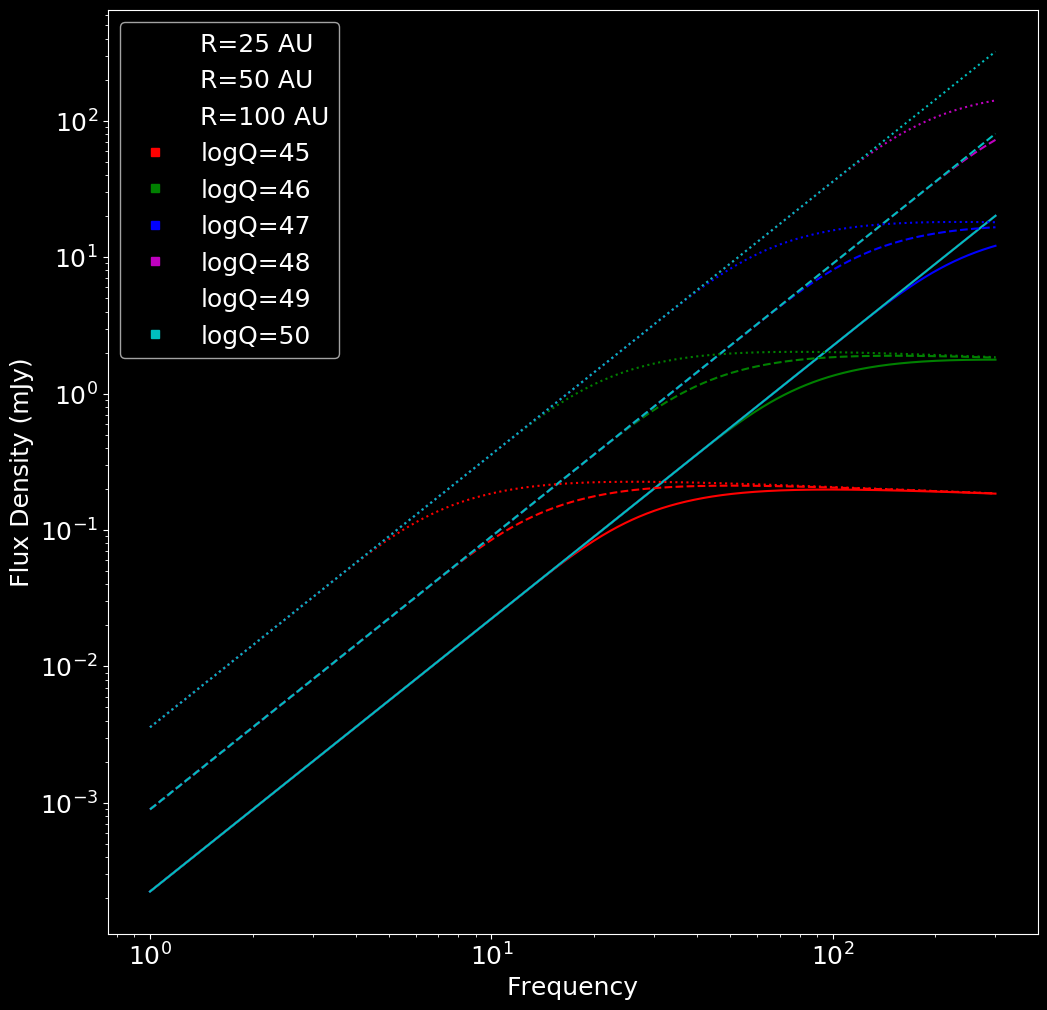

In [46]:
freqs = np.linspace(1,300,1000)*u.GHz

pl.figure(1, figsize=(12,12)).clf()
colors = [x for x in 'rgbmkc']

pl.gca().set_prop_cycle(color=colors)

#pl.figure(2, figsize=(12,12)).clf()
#pl.figure(3, figsize=(12,12)).clf()

radius = 100*u.au
qlycs = np.logspace(45,50,6)*u.s**-1

for radius, linestyle in zip((25,50,100,)*u.au, ('-','--',':','-.')):

    seds_K = [Tb(Te=7000*u.K, nu=freqs, EM=EMfunc(R=radius, Qlyc=qlyc),)
              for qlyc in qlycs]

    seds = [Snu_freefree(Te=7000*u.K, nu=freqs, R=radius, Qlyc=qlyc, beam=40000*u.au,
            angular_beam=10*u.arcsec,)
            for qlyc in qlycs]
    taus = [tau(freqs, EMfunc(Qlyc=qlyc, R=radius))
            for qlyc in qlycs]
    labels = ["R={0} Q={1}".format(radius, qlyc) for qlyc in qlycs]

    pl.figure(1)
    lines = pl.loglog(freqs, np.transpose(seds), linestyle=linestyle, label=labels, )
 #   pl.figure(2)
 #   x = pl.loglog(freqs, np.transpose(taus), linestyle=linestyle, label=labels, )
 #   pl.figure(3)
 #   x = pl.loglog(freqs, np.transpose(seds_K), linestyle=linestyle, label=labels, )
pl.figure(1)
pl.xlabel("Frequency")
pl.ylabel("Flux Density (mJy)")
pl.legend((pl.Line2D([0],[0],linestyle='-', color='k'),
           pl.Line2D([0],[0],linestyle='--', color='k'),
           pl.Line2D([0],[0],linestyle=':', color='k'),)
          + tuple(pl.Line2D([0],[0],marker='s',linestyle='none', color=colors[ii])
                  for ii in range(len(qlycs)))
          ,
          ('R=25 AU','R=50 AU','R=100 AU',) + tuple("logQ={0}".format(int(np.log10(qlyc.value))) for qlyc in qlycs)
          ,
         )

### Aside: try to reproduce Scoville 2003 eqn 1 from Osterbrock

$$F_{Pa\alpha} = 6.41\times 10^{-26} (T_e/6000 K)^{-0.87} \frac{n_e n_p l a_{pix}}{4 \pi d^2} \mathrm{erg~s}^{-1} \mathrm{cm^{-2}}$$

Osterbrock tbl 4.4 gives $$\frac{4\pi j_{H\beta}}{n_e n_p} = 2.22 \times10^{-25} \mathrm{erg~s}^{-1} \mathrm{cm^{3}}$$ and $$\frac{j_{Pa\alpha}}{j_{H\beta}} = 0.396$$ for T=5000, n=$10^4$ cm$^{-3}$, which is close to but not exactly 6000 K.


In [47]:
tbl4pt4paa = 2.22e-25 * 0.396
tbl4pt4paa_to_scoville_ratio = 2.22e-25 * 0.396/6.41e-26
temp_for_scoville_num = (tbl4pt4paa_to_scoville_ratio**(1/-0.87))*600
tbl4pt4paa,tbl4pt4paa_to_scoville_ratio,temp_for_scoville_num

(8.791200000000001e-26, 1.3714820592823715, 417.31254922000363)

Short answer, I think we came to a really close value, but it's not the same.  Maybe there's a small geometric factor hidden in there, since $a_{pix}$ is the "projected area" of the pixel, but I have a hard time seeing how you'd come to that.

Scoville didn't say anything about units of $d$ or $a$.

In [48]:
# area in steradians divided by distance in parsecs, give or take
(0.0753/206265)**2 / (4*np.pi*(8000*u.pc.to(u.cm))**2), (0.0753)**2 / (4*np.pi*(8000*u.pc.to(u.cm))**2)

(1.7403954599089032e-59, 7.404556033227823e-49)

In [49]:
# Typical flux toward Sgr A
snu_sgra_scov = 25*10**-16*u.erg/u.s/u.cm**2/(0.0753*u.arcsec)**2
snu_sgra_scov = 4.3*10**-14*u.erg/u.s/u.cm**2/(0.0753*u.arcsec)**2 # from S4.2
sb_sgra_scov = (snu_sgra_scov/nu_paa).to(u.Jy/u.sr)
snu_sgra_scov, sb_sgra_scov

(<Quantity 7.58365387e-12 erg / (arcsec2 cm2 s)>,
 <Quantity 2.01859081e+08 Jy / sr>)

Osterbrock eqn 4.14 is $$\frac{4 \pi j_{nn'}}{h \nu_{nn'}} = n_p n_e \alpha_{nn',eff}$$

which rearranges to 
 $$\frac{4 \pi j_{nn'}}{n_p n_e} = h \nu_{nn'} \alpha_{nn',eff}$$
 
so $h \nu \alpha_{eff} EM$ is the flux in erg s$^{-1}$ cm$^{-2}$

In [50]:
snu_paa(), alpha_paa, EMfunc(), (EMfunc()*alpha_paa*wl_paa.to(u.erg, u.spectral())).to(u.erg/u.s/u.cm**2)

(<Quantity 20080806.71111409 mJy / sr>,
 <Quantity 1.01808e-14 cm3 / s>,
 <Quantity 4062.84037227 pc / cm6>,
 <Quantity 0.00013518 erg / (cm2 s)>)

In [51]:
# sanity check: does my computation of surface brightness self-consistently match that of Scovilles?
# used eqn 7 for density, length, but then switched to the values just below eqn 7 in s4.2
(snu_paa(Te=6000*u.K, EM=(2.5e4*u.cm**-3)**2*1e17*u.cm)).to(u.Jy/u.sr) / sb_sgra_scov
# am i high by a factor of pi?

<Quantity 0.98861056>